# Random Forest

- Total dataset size: 135 samples
- Training set: 101 samples
- Testing set: 35 samples

Features used:

- LTA precipitation (mmpa)
- LTA PET (mm)
- Aridity idx
- MDT
- Rainfall seasonality
- Soil group (cat)
- Landcover (cat.)
- slope
- percent clay
- percent sand
- percent silt

In [37]:
import pandas as pd
import numpy as np
from matplotlib import cm
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn import metrics
from sklearn.metrics import mean_squared_error, root_mean_squared_error
#%matplotlib inline
from matplotlib import colors
from matplotlib.ticker import PercentFormatter
import rasterio
import utils
#from utils import getAllCoordinates

In [38]:
file = pd.read_csv('C:/Users/35191/Desktop/ThesisData/piezometers/all_variables.csv')
# OMIT ZERO RECHARGE SAMPLES
file = file[file['R_mm_year'] > 0]
# extract data only for one-hot encoding
data = file.drop(columns=['lon', 'lat', 'borehole_name'])
data

,R_mm_year,precip_mm_year,ETP_mm_year,aridity_index,rainfall_seasonality,elevation,terrain_slope,landcover_cat,land_use_type,percent_clay,percent_sand,percent_silt,soil_classification,soil_classification_code
0,178.83,870.64220,1089.9006,0.798827,0.060306,349.0,89.909966,13,212 - Permanently irrigated land,10.232822,54.222443,35.544740,FLUVISSOLOS,104
1,86.42,499.82016,1301.8915,0.383918,0.064150,235.0,89.988840,17,223 - Olive groves,18.929375,45.764140,35.306488,LUVISSOLOS,804
2,9.75,569.83300,1289.9307,0.441755,0.064540,207.0,89.993286,22,244 - Agro-forestry areas,19.767477,46.971252,33.261270,LUVISSOLOS,807
4,42.80,499.82016,1301.8915,0.383918,0.064150,189.0,89.988840,1,111 - Continuous urban fabric,26.853899,37.805702,35.340400,LUVISSOLOS,804
5,62.77,515.59110,1303.9972,0.395393,0.063832,215.0,89.993540,12,211 - Non-irrigated arable land,26.435650,36.204662,37.359688,LUVISSOLOS,803
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
129,54.37,1045.85880,1107.4349,0.944398,0.062389,264.0,89.994430,15,221 - Vineyards,12.681211,50.982796,36.335990,CAMBISSOLOS,717
130,20.42,1066.19510,1111.6426,0.959117,0.063095,267.0,89.995820,25,313 - Mixed forest,13.869223,61.871440,24.259338,CAMBISSOLOS,716
131,99.07,946.53955,1219.5374,0.776146,0.065290,192.0,89.997790,19,241 - Annual crops associated with permanent c...,20.674896,48.108430,31.216675,CAMBISSOLOS,717
133,412.09,865.89150,1264.6675,0.684679,0.065707,117.0,89.994385,29,324 - Transitional woodland-shrub,23.431578,39.882050,36.686370,LITOSSOLOS,303


In [39]:
# encode categorical variables
labelencoder = LabelEncoder()
data['land_use_type_cat'] = labelencoder.fit_transform(data['land_use_type'])
data['soil_class_cat'] = labelencoder.fit_transform(data['soil_classification'])

# remove categorical variables
data = data.drop('land_use_type', axis = 1)
data = data.drop('landcover_cat', axis = 1)
data = data.drop('soil_classification', axis = 1)
data = data.drop('soil_classification_code', axis = 1)
data

,R_mm_year,precip_mm_year,ETP_mm_year,aridity_index,rainfall_seasonality,elevation,terrain_slope,percent_clay,percent_sand,percent_silt,land_use_type_cat,soil_class_cat
0,178.83,870.64220,1089.9006,0.798827,0.060306,349.0,89.909966,10.232822,54.222443,35.544740,5,1
1,86.42,499.82016,1301.8915,0.383918,0.064150,235.0,89.988840,18.929375,45.764140,35.306488,8,3
2,9.75,569.83300,1289.9307,0.441755,0.064540,207.0,89.993286,19.767477,46.971252,33.261270,13,3
4,42.80,499.82016,1301.8915,0.383918,0.064150,189.0,89.988840,26.853899,37.805702,35.340400,0,3
5,62.77,515.59110,1303.9972,0.395393,0.063832,215.0,89.993540,26.435650,36.204662,37.359688,4,3
...,...,...,...,...,...,...,...,...,...,...,...,...
129,54.37,1045.85880,1107.4349,0.944398,0.062389,264.0,89.994430,12.681211,50.982796,36.335990,6,0
130,20.42,1066.19510,1111.6426,0.959117,0.063095,267.0,89.995820,13.869223,61.871440,24.259338,16,0
131,99.07,946.53955,1219.5374,0.776146,0.065290,192.0,89.997790,20.674896,48.108430,31.216675,10,0
133,412.09,865.89150,1264.6675,0.684679,0.065707,117.0,89.994385,23.431578,39.882050,36.686370,18,2


In [40]:
data.info()
data.head()

<class 'pandas.core.frame.DataFrame'>
Index: 128 entries, 0 to 134
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   R_mm_year             128 non-null    float64
 1   precip_mm_year        128 non-null    float64
 2   ETP_mm_year           128 non-null    float64
 3   aridity_index         128 non-null    float64
 4   rainfall_seasonality  128 non-null    float64
 5   elevation             128 non-null    float64
 6   terrain_slope         128 non-null    float64
 7   percent_clay          128 non-null    float64
 8   percent_sand          128 non-null    float64
 9   percent_silt          128 non-null    float64
 10  land_use_type_cat     128 non-null    int32  
 11  soil_class_cat        128 non-null    int32  
dtypes: float64(10), int32(2)
memory usage: 12.0 KB


,R_mm_year,precip_mm_year,ETP_mm_year,aridity_index,rainfall_seasonality,elevation,terrain_slope,percent_clay,percent_sand,percent_silt,land_use_type_cat,soil_class_cat
0,178.83,870.64220,1089.9006,0.798827,0.060306,349.0,89.909966,10.232822,54.222443,35.544740,5,1
1,86.42,499.82016,1301.8915,0.383918,0.064150,235.0,89.988840,18.929375,45.764140,35.306488,8,3
2,9.75,569.83300,1289.9307,0.441755,0.064540,207.0,89.993286,19.767477,46.971252,33.261270,13,3
4,42.80,499.82016,1301.8915,0.383918,0.064150,189.0,89.988840,26.853899,37.805702,35.340400,0,3
5,62.77,515.59110,1303.9972,0.395393,0.063832,215.0,89.993540,26.435650,36.204662,37.359688,4,3


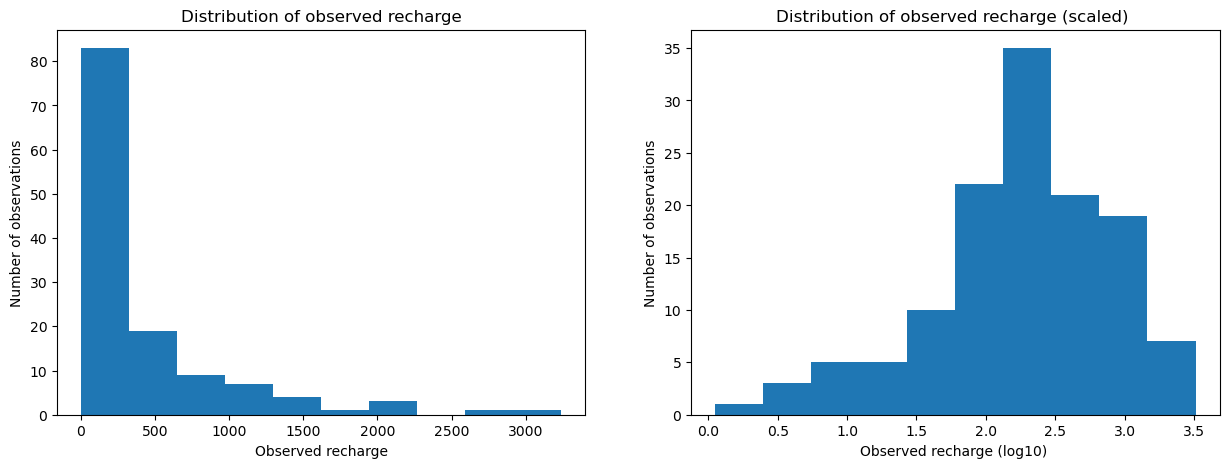

In [41]:
n_bins = 10

fig, axs = plt.subplots(1,2, figsize=(15,5))
axs = axs.flatten()
# We can set the number of bins with the `bins` kwarg
axs[0].hist(data['R_mm_year'], bins=n_bins)
axs[0].set_title('Distribution of observed recharge')
axs[0].set_xlabel('Observed recharge')
axs[0].set_ylabel('Number of observations')

axs[1].hist(np.log10(data['R_mm_year']), bins=n_bins)
axs[1].set_title('Distribution of observed recharge (scaled) ')
axs[1].set_xlabel('Observed recharge (log10) ')
axs[1].set_ylabel('Number of observations')

plt.show()

In [42]:
X_train, X_test, y_train, y_test = train_test_split(
    data.drop("R_mm_year", axis=1),
    data["R_mm_year"],
    test_size=0.25,
    random_state=42,
) # random_state is used to make sure that the split is always the same

# Inspect the Data

Visualization

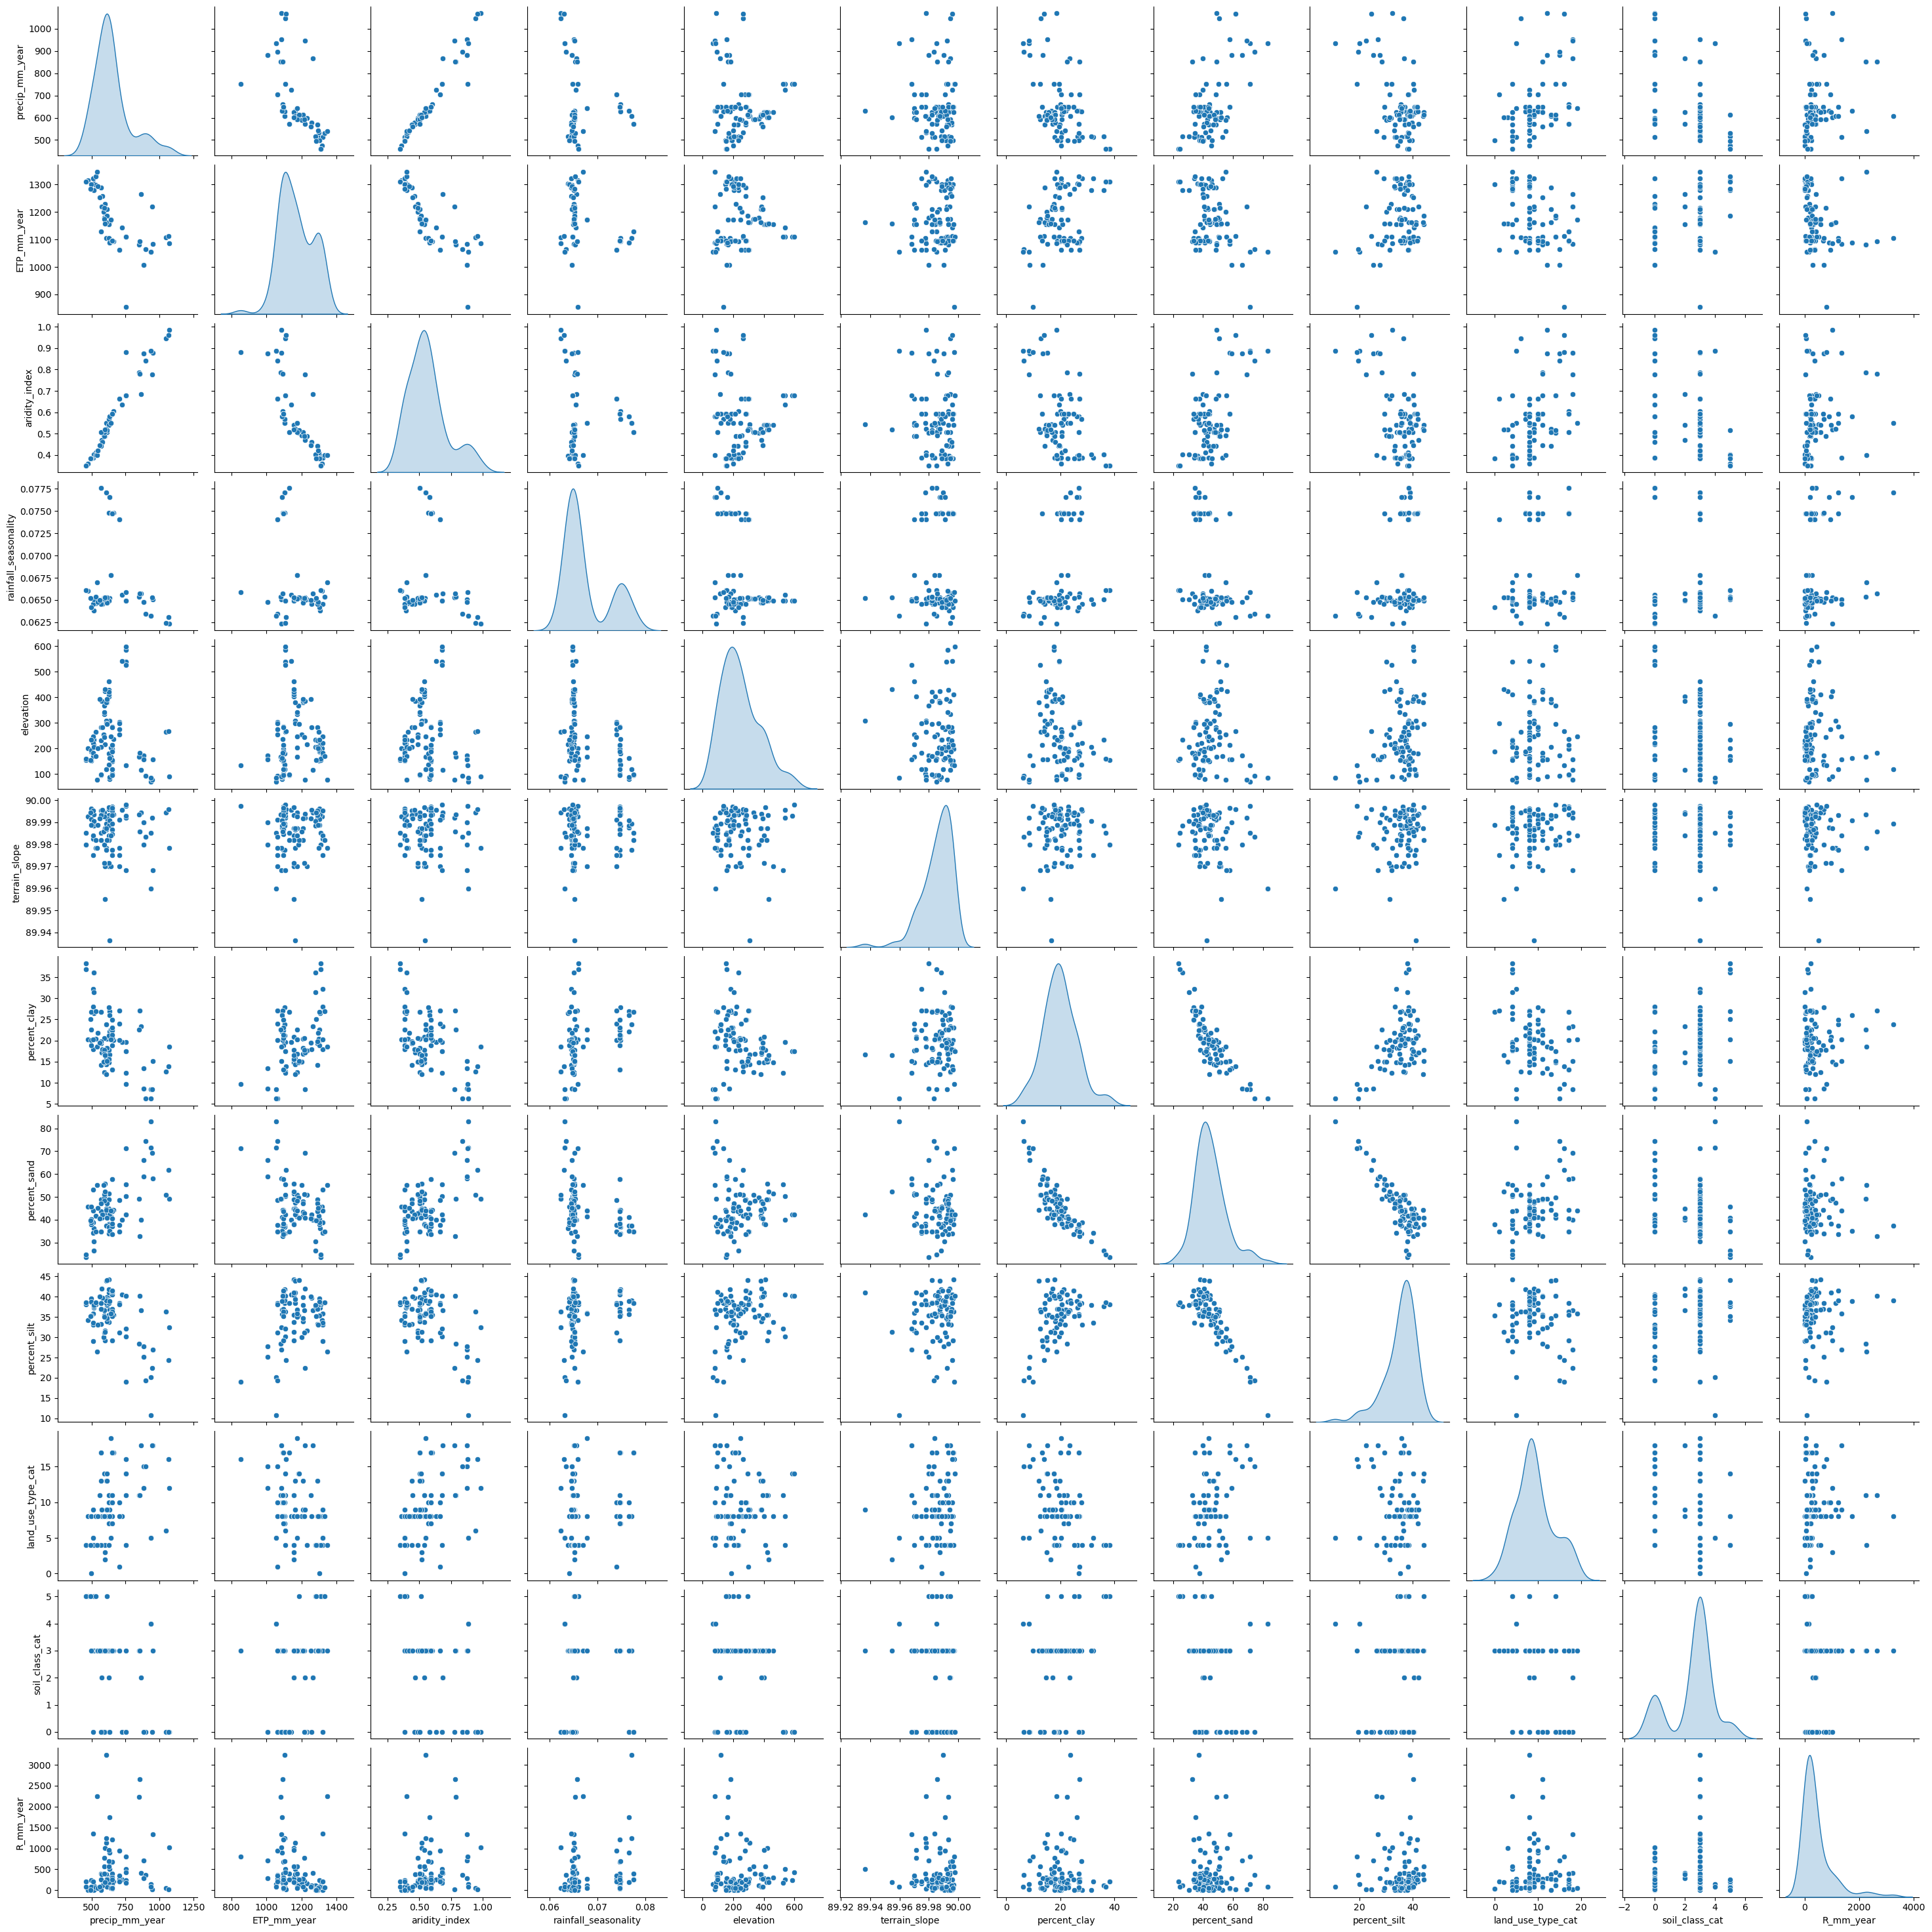

In [43]:
import seaborn as sns
sns.pairplot(
    X_train.assign(R_mm_year=y_train),
    diag_kind="kde",
);

## Descriptive Statistics

- count: the size of the training set
- mean: arithmetic mean
- std: sample standard deviation
- min: minimum value
- 25%: 25% of the values fall below this number
- 50%: 50th  percentile also called the median. 50% of the values fall below this number and 50% of the values fall above this number
- 75%: 75% of the values fall below this number
- max: maximum value

In [44]:
X_train.assign(R_mm_year=y_train).describe().T

,count,mean,std,min,25%,50%,75%,max
precip_mm_year,96.0,650.056441,134.146692,460.595340,571.711000,625.171630,652.550383,1069.211000
ETP_mm_year,96.0,1169.576024,94.669877,853.423770,1095.580600,1156.637100,1253.680625,1347.449100
aridity_index,96.0,0.565406,0.150913,0.351418,0.467412,0.540806,0.595825,0.984658
rainfall_seasonality,96.0,0.067637,0.004654,0.062337,0.064741,0.065183,0.074047,0.077557
elevation,96.0,248.064867,124.239939,69.000000,157.750000,219.000000,307.500000,598.000000
terrain_slope,96.0,89.985459,0.010328,89.936340,89.979866,89.987395,89.993286,89.997900
percent_clay,96.0,19.836968,6.177580,6.244911,15.556306,19.669569,23.160640,38.327620
percent_sand,96.0,44.933683,10.451534,23.646011,38.071937,43.450130,49.333419,83.027060
percent_silt,96.0,35.229403,5.892707,10.728027,33.115023,36.487983,38.876638,44.181850
land_use_type_cat,96.0,9.250000,4.287067,0.000000,7.750000,8.000000,11.000000,19.000000


In [45]:
# Labels are the values we want to predict
#labels = data['Recharge_mmpa']
labels = np.log10(data['R_mm_year'])
# Remove the labels from the features
data = data.drop('R_mm_year', axis = 1)
# Saving feature names for later use
feature_list = list(data.columns)
# Convert to numpy array
features = np.array(data)

# Experiment 1: 100 runs for reliable importance measure

In [46]:
# collect all importances, R2 and oob values to calculate the average over 100 models
importances = []
train_r2=[]
test_r2=[]
oobs=[]
train_r2_untransf=[]
test_r2_untransf=[]
# find the best model based on the lowest RMSE
best_model = None
best_r2 = 0
best_importances = None
best_train_features, best_test_features, best_train_labels, best_test_labels = None, None, None, None
best_rmse = 300
# find the worst model based on the highest RMSE
worst_model = None
worst_r2 = 100
worst_train_features, worst_test_features, worst_train_labels, worst_test_labels = None, None, None, None
worst_rmse = 0

# run model 100 times
for i in range(0,100):
    # Split the data into training and testing sets
    train_features, test_features, train_labels, test_labels = train_test_split(features, labels, test_size = 0.25)    
    # Instantiate models with 2000 decision trees
    rf = RandomForestRegressor(n_estimators = 2000, max_features=0.33, oob_score=True)
    
    # Train the model on training data
    rf.fit(train_features, train_labels)
    
    # Use the forest's predict method on the test data
    predictions = rf.predict(test_features)
    train_predictions = rf.predict(train_features)
    current_r2 = metrics.r2_score(test_labels, predictions)
    current_train_r2 = metrics.r2_score(train_labels, train_predictions)
    
    train_r2.append(current_train_r2)
    test_r2.append(current_r2)
    train_r2_untransf.append(metrics.r2_score(10**train_labels, 10**train_predictions))
    test_r2_untransf.append(metrics.r2_score(10**test_labels, 10**predictions))
    oobs.append(rf.oob_score_)
    print(f'Out-of-bag score estimate: {rf.oob_score_:>5.3}; Train R-2: {current_train_r2:>5.3}, Test R-2: {current_r2:>5.3}')

    current_rmse = root_mean_squared_error(10**test_labels, 10**predictions)
    print(f"current rmse {current_rmse}")
    if current_r2>best_r2:
        best_rmse = current_rmse
        best_r2 = current_r2
        best_model = rf
        best_importances = rf.feature_importances_
        best_train_features, best_test_features, best_train_labels, best_test_labels = train_features, test_features, train_labels, test_labels
    
    if current_r2<worst_r2:
        worst_r2 = current_r2
        worst_rmse = current_rmse
        worst_model = rf
        worst_train_features, worst_test_features, worst_train_labels, worst_test_labels = train_features, test_features, train_labels, test_labels
    importances.append(rf.feature_importances_)

Out-of-bag score estimate:  0.23; Train R-2: 0.892, Test R-2: 0.176
current rmse 584.7731466243519
Out-of-bag score estimate: 0.185; Train R-2: 0.884, Test R-2: 0.332
current rmse 656.7183196487621
Out-of-bag score estimate: 0.222; Train R-2: 0.896, Test R-2: 0.266
current rmse 711.3739853099727
Out-of-bag score estimate: 0.246; Train R-2: 0.894, Test R-2: 0.0948
current rmse 520.5779617833153
Out-of-bag score estimate: 0.343; Train R-2: 0.907, Test R-2: -0.053
current rmse 544.9973056403041
Out-of-bag score estimate: 0.287; Train R-2: 0.902, Test R-2: 0.236
current rmse 492.20454328005064
Out-of-bag score estimate: 0.231; Train R-2: 0.899, Test R-2: 0.222
current rmse 570.6150114672529
Out-of-bag score estimate: 0.295; Train R-2: 0.904, Test R-2: -0.0577
current rmse 373.77120671138243
Out-of-bag score estimate: 0.0675; Train R-2: 0.873, Test R-2: 0.349
current rmse 696.9404213605748
Out-of-bag score estimate:  0.29; Train R-2: 0.905, Test R-2: 0.0575
current rmse 613.315730635134
Out

In [47]:
from sklearn.metrics import mean_squared_error, root_mean_squared_error

best_predictions = best_model.predict(best_test_features)
# Use the forest's predict method on the training data
best_train_predictions = best_model.predict(best_train_features)

print("+++ METRICS ON LOG-TRANSFORMED VALUES +++")
print(f"Max R2 train: {np.array(train_r2).max()}")
print(f"Min R2 train: {np.array(train_r2).min()}")
print(f"Mean R2 train: {np.array(train_r2).mean()}")
print(f'Best RMSE train: {root_mean_squared_error(10**best_train_labels, 10**best_train_predictions)}\n')

print(f"Max oob: {np.array(oobs).max()}")
print(f"Min oob: {np.array(oobs).min()}")
print(f"Mean oob: {np.array(oobs).mean()}\n")

print(f"Max R2 test: {np.array(test_r2).max()}")
print(f"Min R2 test: {np.array(test_r2).min()}")
print(f"Mean R2 test: {np.array(test_r2).mean()}")
print(f'Best RMSE test: {root_mean_squared_error(10**best_test_labels, 10**best_predictions)}\n')

print("+++ METRICS ON BACK TRANSFORMED VALUES +++")
print(f"Max R2 train: {np.array(train_r2_untransf).max()}")
print(f"Min R2 train: {np.array(train_r2_untransf).min()}")
print(f"Mean R2 train: {np.array(train_r2_untransf).mean()}\n")
print(f"Max R2 test: {np.array(test_r2_untransf).max()}")
print(f"Min R2 test: {np.array(test_r2_untransf).min()}")
print(f"Mean R2 test: {np.array(test_r2_untransf).mean()}")

+++ METRICS ON LOG-TRANSFORMED VALUES +++
Max R2 train: 0.920926126495528
Min R2 train: 0.8723548775016633
Mean R2 train: 0.8961713707983191
Best RMSE train: 359.6262565065408

Max oob: 0.4363531925610018
Min oob: 0.06750883493457593
Mean oob: 0.23997297291871353

Max R2 test: 0.45319541408243735
Min R2 test: -0.655772981528155
Mean R2 test: 0.17735850695155705
Best RMSE test: 437.7079574588548

+++ METRICS ON BACK TRANSFORMED VALUES +++
Max R2 train: 0.7656998081844809
Min R2 train: 0.5584111231793241
Mean R2 train: 0.6696781600457108

Max R2 test: 0.5479120016490575
Min R2 test: -0.5277728771811223
Mean R2 test: 0.03182554244979237


In [53]:
print("+++ Best model metrics +++\n")
print("--- log transformed ---")
print(f'Out-of-bag R-2 score estimate: {best_model.oob_score_:>5.3}')
print('Best R2 train: ', best_model.score(best_train_features, best_train_labels))
print(f'Best R2 test:  {best_model.score(best_test_features, best_test_labels)}\n')
print("--- back transformed ---")
print(f'Best RMSE train: {root_mean_squared_error(10**best_train_labels, 10**best_train_predictions)}')
print(f"Best RMSE test: {best_rmse}")
print(f"Best R2 train: {metrics.r2_score(10**best_train_labels, 10**best_train_predictions)}")
print(f"Best R2 test: {metrics.r2_score(10**best_test_labels, 10**best_predictions)}")

+++ Best model metrics +++

--- log transformed ---
Out-of-bag R-2 score estimate: 0.105
Best R2 train:  0.8751392295364224
Best R2 test:  0.45319541408243735

--- back transformed ---
Best RMSE train: 359.6262565065408
Best RMSE test: 437.7079574588548
Best R2 train: 0.6009801758215019
Best R2 test: 0.32197857821231013


In [54]:
worst_predictions = worst_model.predict(worst_test_features)
# Use the forest's predict method on the training data
worst_train_predictions = worst_model.predict(worst_train_features)

print("+++ Worst model metrics +++\n")
print("--- log transformed ---")
print(f'Out-of-bag R-2 score estimate: {worst_model.oob_score_:>5.3}')
print('worst R2 train: ', worst_model.score(best_train_features, worst_train_labels))
print(f'worst R2 test:  {worst_model.score(best_test_features, worst_test_labels)}\n')
print("--- back transformed ---")
print(f'worst RMSE train: {root_mean_squared_error(10**worst_train_labels, 10**worst_train_predictions)}')
print(f"worst RMSE test: {worst_rmse}")
print(f"worst R2 train: {metrics.r2_score(10**worst_train_labels, 10**worst_train_predictions)}")
print(f"worst R2 test: {metrics.r2_score(10**worst_test_labels, 10**worst_predictions)}")

+++ Worst model metrics +++

--- log transformed ---
Out-of-bag R-2 score estimate:  0.42
worst R2 train:  -0.4208096850374039
worst R2 test:  -1.125251028423635

--- back transformed ---
worst RMSE train: 280.8113607688503
worst RMSE test: 606.6884117564952
worst R2 train: 0.7609761727539505
worst R2 test: -0.3893610399821017


In [55]:
importances = np.array(importances)
mean_importances = np.mean(importances, axis=0)
# List of tuples with variable and importance
feature_importances = [(feature, round(importance, 2)) for feature, importance in zip(feature_list, mean_importances)]
# Sort the feature importances by most important first
feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)
# Print out the feature and importances 
print('Mean feature importance')
[print('Variable: {:20} Importance: {}'.format(*pair)) for pair in feature_importances];

Mean feature importance
Variable: ETP_mm_year          Importance: 0.15
Variable: precip_mm_year       Importance: 0.13
Variable: aridity_index        Importance: 0.13
Variable: rainfall_seasonality Importance: 0.1
Variable: elevation            Importance: 0.09
Variable: terrain_slope        Importance: 0.09
Variable: percent_silt         Importance: 0.09
Variable: percent_sand         Importance: 0.08
Variable: percent_clay         Importance: 0.07
Variable: land_use_type_cat    Importance: 0.05
Variable: soil_class_cat       Importance: 0.02


In [56]:
# List of tuples with variable and importance
feature_importances = [(feature, round(importance, 2)) for feature, importance in zip(feature_list, best_importances)]
# Sort the feature importances by most important first
feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)
# Print out the feature and importances
print('Best performing model: feature importance')
[print('Variable: {:20} Importance: {}'.format(*pair)) for pair in feature_importances];

Best performing model: feature importance
Variable: ETP_mm_year          Importance: 0.16
Variable: precip_mm_year       Importance: 0.11
Variable: aridity_index        Importance: 0.11
Variable: percent_silt         Importance: 0.11
Variable: rainfall_seasonality Importance: 0.1
Variable: elevation            Importance: 0.1
Variable: percent_sand         Importance: 0.09
Variable: terrain_slope        Importance: 0.08
Variable: percent_clay         Importance: 0.08
Variable: land_use_type_cat    Importance: 0.05
Variable: soil_class_cat       Importance: 0.01


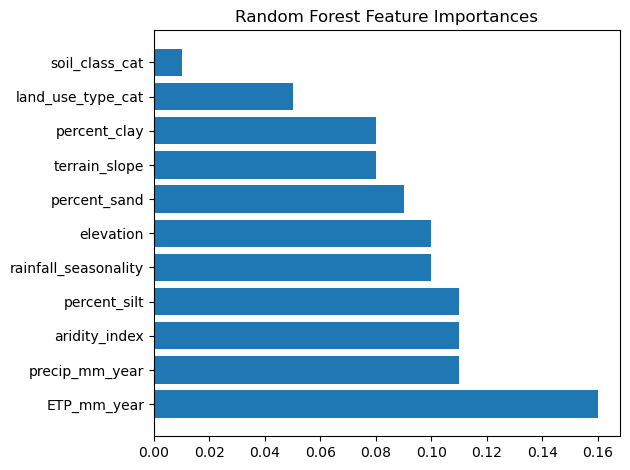

In [57]:
feature_names = [f[0] for f in feature_importances]
y_ticks = np.arange(0, len(feature_names))
fig, ax = plt.subplots()
ax.barh(y_ticks, [f[1] for f in feature_importances])
ax.set_yticks(y_ticks)
ax.set_yticklabels(feature_names)
ax.set_title("Random Forest Feature Importances")
fig.tight_layout()
plt.show()

## Permutation importance

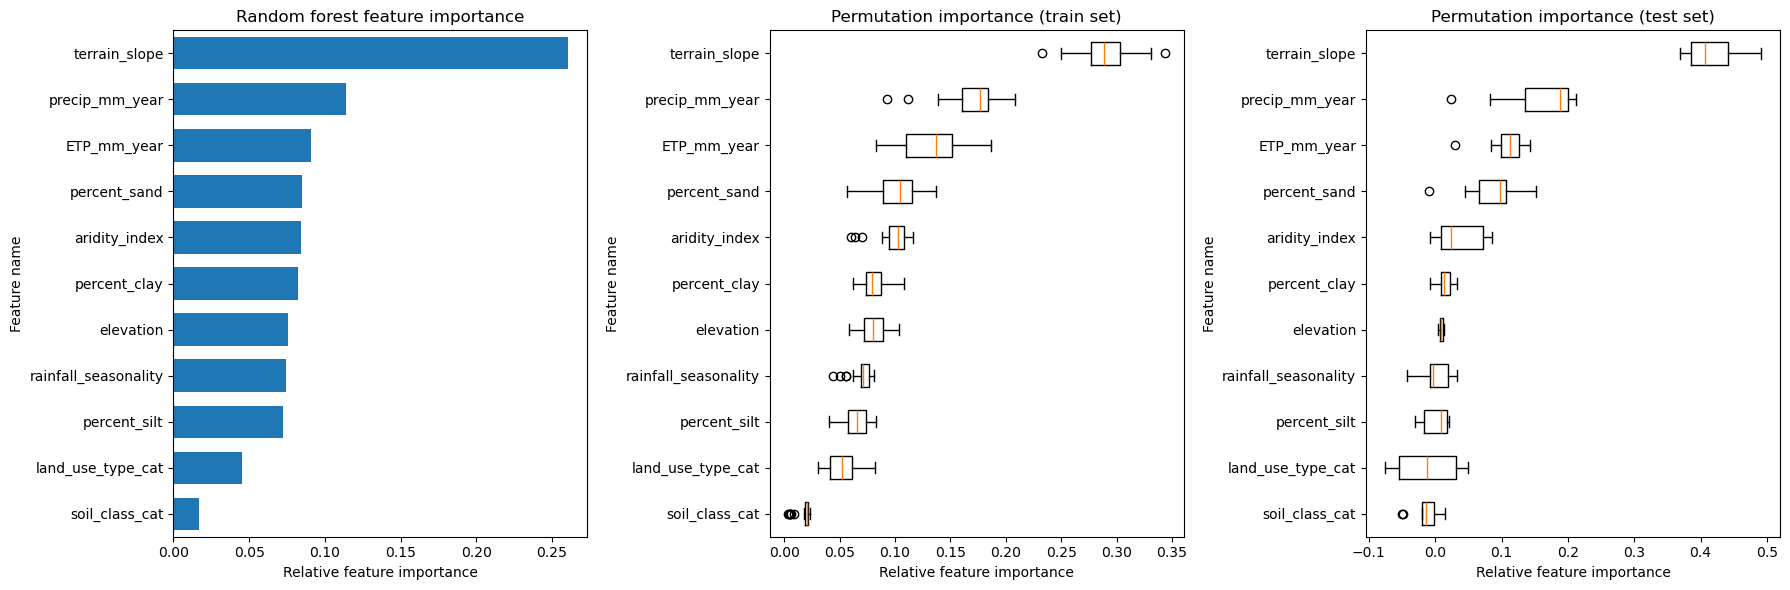

In [30]:
from sklearn.inspection import permutation_importance
feature_names = data.columns

# permutation importance on training set
result_train = permutation_importance(best_model, best_train_features, best_train_labels, n_repeats=30,
                                random_state=42)
perm_sorted_idx = result_train.importances_mean.argsort()

tree_importance_sorted_idx = np.argsort(best_model.feature_importances_)
tree_indices = np.arange(0, len(best_model.feature_importances_)) + 0.5

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 6))
ax1.barh(tree_indices,
         best_model.feature_importances_[tree_importance_sorted_idx], height=0.7)
ax1.set_title('Random forest feature importance')
ax1.set_ylabel('Feature name')
ax1.set_xlabel('Relative feature importance')
ax1.set_yticks(tree_indices)
ax1.set_yticklabels(feature_names[tree_importance_sorted_idx])
ax1.set_ylim((0, len(best_model.feature_importances_)))
ax2.boxplot(result_train.importances[perm_sorted_idx].T, vert=False,
            labels=feature_names[tree_importance_sorted_idx])
ax2.set_title('Permutation importance (train set)')
ax2.set_ylabel('Feature name')
ax2.set_xlabel('Relative feature importance')

# permutation importance on test set
result_test = permutation_importance(best_model, best_test_features, best_test_labels, n_repeats=10,
                                random_state=42)

perm_sorted_idx = result_test.importances_mean.argsort()
ax3.boxplot(result_test.importances[perm_sorted_idx].T, vert=False,
            labels=feature_names[tree_importance_sorted_idx])
ax3.set_title('Permutation importance (test set)')
ax3.set_ylabel('Feature name')
ax3.set_xlabel('Relative feature importance')


fig.tight_layout()
plt.show()

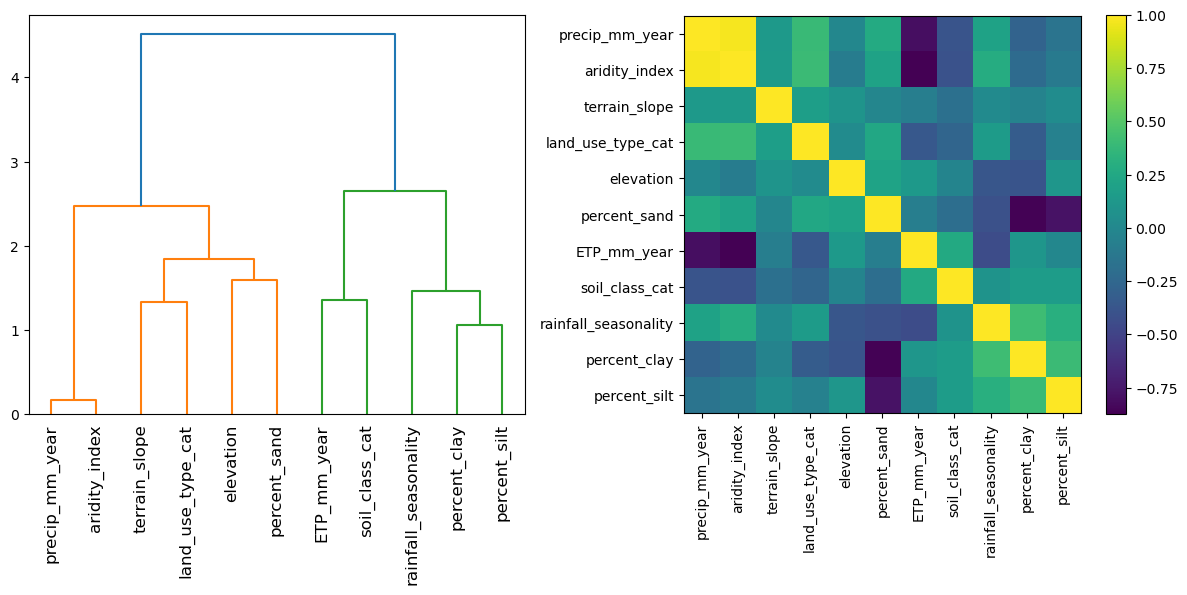

In [31]:
# handle multicollinearity
from scipy.stats import spearmanr
from scipy.cluster import hierarchy

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))
corr = spearmanr(features).correlation
corr_linkage = hierarchy.ward(corr)
dendro = hierarchy.dendrogram(
    corr_linkage, labels=feature_names, ax=ax1, leaf_rotation=90
)
dendro_idx = np.arange(0, len(dendro['ivl']))

im = ax2.imshow(corr[dendro['leaves'], :][:, dendro['leaves']])
ax2.set_xticks(dendro_idx)
ax2.set_yticks(dendro_idx)
ax2.set_xticklabels(dendro['ivl'], rotation='vertical')
ax2.set_yticklabels(dendro['ivl'])
fig.tight_layout()
fig.colorbar(im)
plt.show()

(-400.0, 400.0)

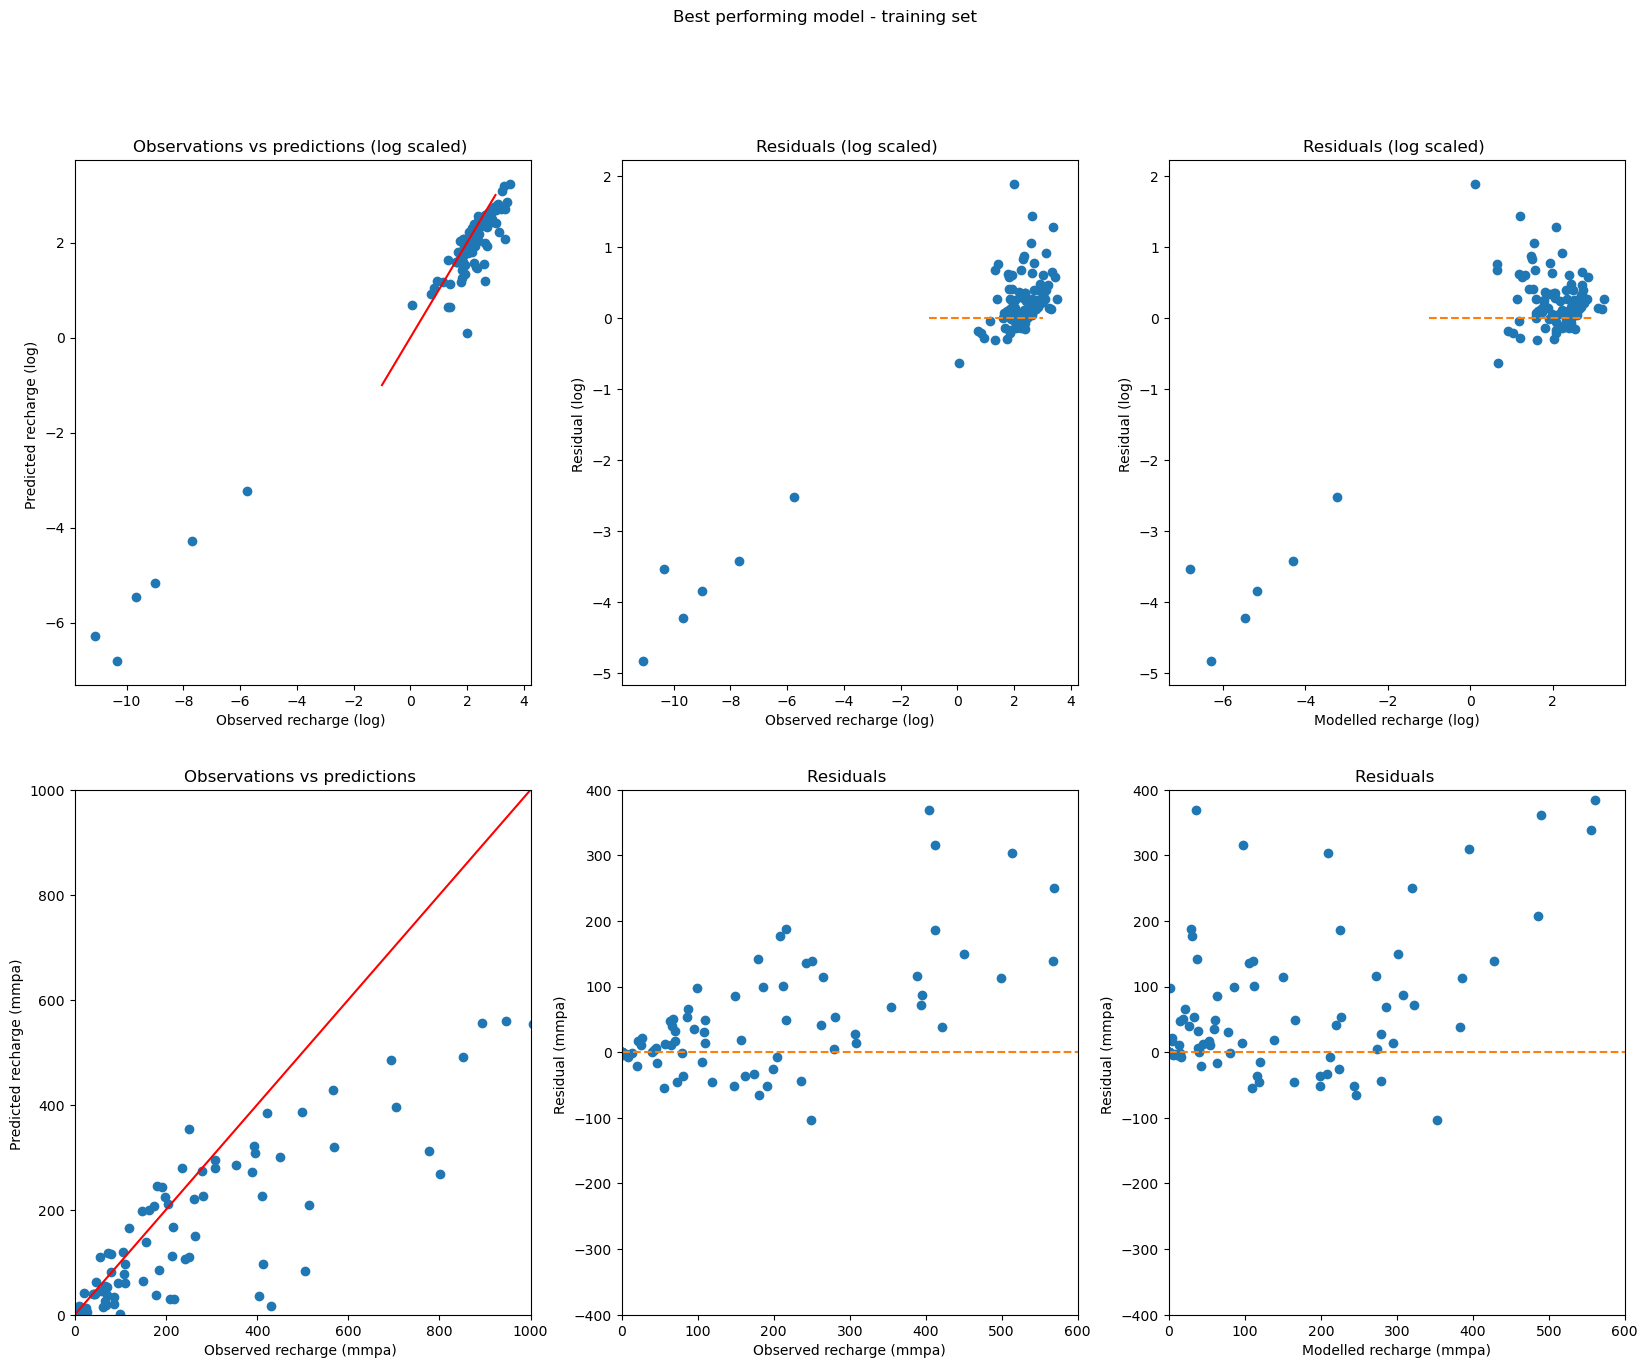

In [33]:
fig, axs = plt.subplots(2,3,figsize=(20,15))
fig.suptitle('Best performing model - training set')
axs = axs.flatten()

axs[0].scatter(best_train_labels, best_train_predictions)
axs[0].plot(range(-1,4), range(-1,4), 'r')
#axs[0].plot(range(0,700), range(0,700), 'r')
axs[0].set_title('Observations vs predictions (log scaled) ')
axs[0].set_xlabel('Observed recharge (log) ')
axs[0].set_ylabel('Predicted recharge (log) ')
#axs[0].set_xlim([0,700])
#axs[0].set_ylim([0,700])

axs[1].plot(best_train_labels, best_train_labels - best_train_predictions,marker='o',linestyle='')
axs[1].plot(range(-1,4), np.zeros((5,)), '--')
#axs[1].plot(range(0,450), np.zeros((450,)), '--')
axs[1].set_title('Residuals (log scaled) ')
axs[1].set_xlabel('Observed recharge (log)')
axs[1].set_ylabel('Residual (log) ')
#axs[1].set_xlim([0,450])
#axs[1].set_ylim([-450,450])

axs[2].plot(best_train_predictions, best_train_labels - best_train_predictions,marker='o',linestyle='')
axs[2].plot(range(-1,4), np.zeros((5,)), '--')
#axs[2].plot(range(0,450), np.zeros((450,)), '--')
axs[2].set_title('Residuals (log scaled) ')
axs[2].set_xlabel('Modelled recharge (log)')
axs[2].set_ylabel('Residual (log) ')
#axs[2].set_xlim([0,450])
#axs[2].set_ylim([-450,450])

axs[3].scatter(10**best_train_labels, 10**best_train_predictions)
#axs[3].plot(range(-1,4), range(-1,4), 'r')
axs[3].plot(range(0,1000), range(0,1000), 'r')
axs[3].set_title('Observations vs predictions ')
axs[3].set_xlabel('Observed recharge (mmpa) ')
axs[3].set_ylabel('Predicted recharge (mmpa) ')
axs[3].set_xlim([0,1000])
axs[3].set_ylim([0,1000])

axs[4].plot(10**best_train_labels, 10**best_train_labels - 10**best_train_predictions,marker='o',linestyle='')
axs[4].plot(range(0,1000), np.zeros((1000,)), '--')
axs[4].set_title('Residuals ')
axs[4].set_xlabel('Observed recharge (mmpa)')
axs[4].set_ylabel('Residual (mmpa) ')
axs[4].set_xlim([0,600])
axs[4].set_ylim([-400,400])

axs[5].plot(10**best_train_predictions, 10**best_train_labels - 10**best_train_predictions,marker='o',linestyle='')
axs[5].plot(range(0,1000), np.zeros((1000,)), '--')
axs[5].set_title('Residuals ')
axs[5].set_xlabel('Modelled recharge (mmpa)')
axs[5].set_ylabel('Residual (mmpa) ')
axs[5].set_xlim([0,600])
axs[5].set_ylim([-400,400])

# n_bins = 10
# axs[2].hist(train_labels, bins=n_bins)
# axs[2].set_title('Distribution of observed recharge in the training set (scaled) ')
# axs[2].set_xlabel('Observed recharge (log10) ')
# axs[2].set_ylabel('Number of observations')
# axs[2].set_xlim([-1,3])
# #axs[2].set_ylim([0,25])

#fig.savefig('Graphics/res_training_best.jpg')

In [35]:
# testing set metrics
print('=== Prediction of testing set - best performing model ===')
print('Mean Absolute Error (MAE):', metrics.mean_absolute_error(best_test_labels, best_predictions))
print('Mean Squared Error (MSE):', metrics.mean_squared_error(best_test_labels, best_predictions))
print('Root Mean Squared Error (RMSE):', root_mean_squared_error(best_test_labels, best_predictions))
print('Mean Absolute Percentage Error (MAPE):', metrics.mean_absolute_percentage_error(best_test_labels, best_predictions))
print('Explained Variance Score:', metrics.explained_variance_score(best_test_labels, best_predictions))
print('Max Error:', metrics.max_error(best_test_labels, best_predictions))
print('Median Absolute Error:', metrics.median_absolute_error(best_test_labels, best_predictions))
print('R^2:', metrics.r2_score(best_test_labels, best_predictions))

=== Prediction of testing set - best performing model ===
Mean Absolute Error (MAE): 0.6742766180948002
Mean Squared Error (MSE): 1.9943576557111038
Root Mean Squared Error (RMSE): 1.4122172834628188
Mean Absolute Percentage Error (MAPE): 0.32119728153998717
Explained Variance Score: 0.5423172419338442
Max Error: 7.5160594467693596
Median Absolute Error: 0.36471818608697293
R^2: 0.5420505481601452


(-400.0, 400.0)

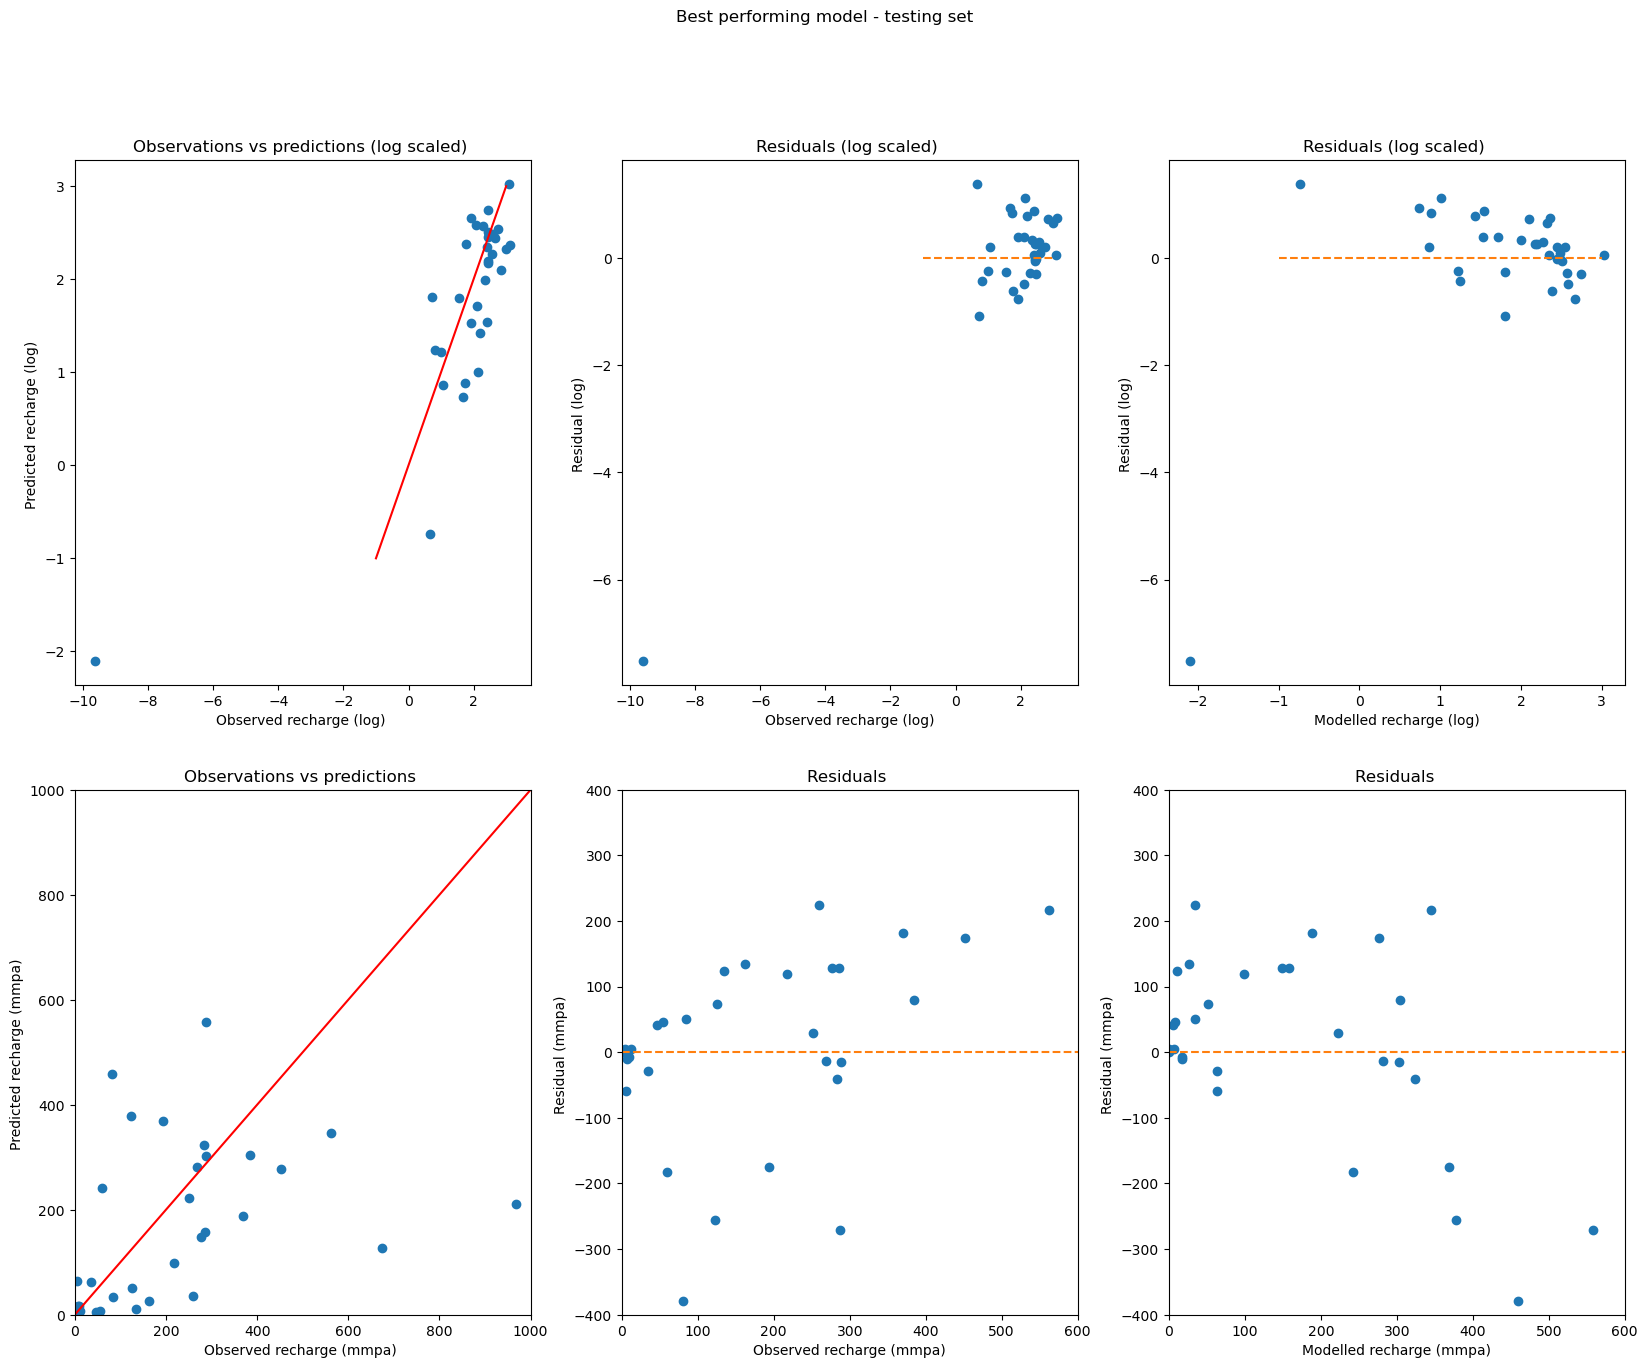

In [36]:
fig, axs = plt.subplots(2,3,figsize=(20,15))
fig.suptitle('Best performing model - testing set')
axs = axs.flatten()

axs[0].scatter(best_test_labels, best_predictions)
axs[
    0].plot(range(-1,4), range(-1,4), 'r')
#axs[0].plot(range(0,700), range(0,700), 'r')
axs[0].set_title('Observations vs predictions (log scaled) ')
axs[0].set_xlabel('Observed recharge (log) ')
axs[0].set_ylabel('Predicted recharge (log) ')
#axs[0].set_xlim([0,700])
#axs[0].set_ylim([0,700])

axs[1].plot(best_test_labels, best_test_labels - best_predictions,marker='o',linestyle='')
axs[1].plot(range(-1,4), np.zeros((5,)), '--')
#axs[1].plot(range(0,450), np.zeros((450,)), '--')
axs[1].set_title('Residuals (log scaled) ')
axs[1].set_xlabel('Observed recharge (log)')
axs[1].set_ylabel('Residual (log) ')
#axs[1].set_xlim([0,450])
#axs[1].set_ylim([-450,450])

axs[2].plot(best_predictions, best_test_labels - best_predictions,marker='o',linestyle='')
axs[2].plot(range(-1,4), np.zeros((5,)), '--')
#axs[2].plot(range(0,450), np.zeros((450,)), '--')
axs[2].set_title('Residuals (log scaled) ')
axs[2].set_xlabel('Modelled recharge (log)')
axs[2].set_ylabel('Residual (log) ')
#axs[2].set_xlim([0,450])
#axs[2].set_ylim([-450,450])

axs[3].scatter(10**best_test_labels, 10**best_predictions)
#axs[3].plot(range(-1,4), range(-1,4), 'r')
axs[3].plot(range(0,1000), range(0,1000), 'r')
axs[3].set_title('Observations vs predictions ')
axs[3].set_xlabel('Observed recharge (mmpa) ')
axs[3].set_ylabel('Predicted recharge (mmpa) ')
axs[3].set_xlim([0,1000])
axs[3].set_ylim([0,1000])

axs[4].plot(10**best_test_labels, 10**best_test_labels - 10**best_predictions,marker='o',linestyle='')
axs[4].plot(range(0,1000), np.zeros((1000,)), '--')
axs[4].set_title('Residuals ')
axs[4].set_xlabel('Observed recharge (mmpa)')
axs[4].set_ylabel('Residual (mmpa) ')
axs[4].set_xlim([0,600])
axs[4].set_ylim([-400,400])

axs[5].plot(10**best_predictions, 10**best_test_labels - 10**best_predictions,marker='o',linestyle='')
axs[5].plot(range(0,1000), np.zeros((1000,)), '--')
axs[5].set_title('Residuals ')
axs[5].set_xlabel('Modelled recharge (mmpa)')
axs[5].set_ylabel('Residual (mmpa) ')
axs[5].set_xlim([0,600])
axs[5].set_ylim([-400,400])

# n_bins = 10
# axs[2].hist(test_labels, bins=n_bins)
# axs[2].set_title('Distribution of observed recharge in the testing set (scaled) ')
# axs[2].set_xlabel('Observed recharge (log10) ')
# axs[2].set_ylabel('Number of observations')
# axs[2].set_xlim([-1,3])

#fig.savefig('Graphics/res_testing_best.jpg')